<a href="https://colab.research.google.com/github/marlanaswann/spr5-kdm1a-conservation-/blob/main/notebooks/04_Variant_Mapping_of_KDM1A_and_SPR_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up & Upload Files


In [ ]:
!pip install biopython
from Bio import AlignIO
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.4 MB/s eta 0:00:00


## Produce a Table of KMDM1A Variants

In [ ]:
print("Upload your ClinVar TXT file (variant_summary.txt):")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ---------------------------
# STEP 2: Read the tab-delimited file
# ---------------------------
df = pd.read_csv(filename, sep='\t', comment='#', low_memory=False)
print(f"Full ClinVar file loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# ---------------------------
# STEP 3: Filter for KDM1A
# ---------------------------
# Some rows contain multiple genes, so we search for "KDM1A" in the Gene(s) field
kdm1a = df[df["Gene(s)"].str.contains("KDM1A", na=False)]
print(f"Filtered KDM1A variants: {kdm1a.shape[0]} rows")

# ---------------------------
# STEP 4: Filter for single nucleotide variants affecting protein
# ---------------------------
kdm1a = kdm1a[
    (kdm1a["Variant type"] == "single nucleotide variant") &
    (kdm1a["Molecular consequence"].str.contains("missense|nonsense|frameshift|stop_gained|start_lost", case=False, na=False))
]
print(f"Protein-altering KDM1A variants: {kdm1a.shape[0]} rows")

# ---------------------------
# STEP 5: Select only key columns for downstream analysis
# ---------------------------
variant_columns = [
    "VariationID",
    "dbSNP ID",
    "Canonical SPDI",   # contains reference/alternate info
    "Variant type",
    "Molecular consequence",
    "Germline classification",
    "Protein change" # Added 'Protein change' column
]

kdm1a_clean = kdm1a[variant_columns].reset_index(drop=True)
kdm1a_clean.head()

# ---------------------------
# STEP 6: Save clean KDM1A variants to CSV
# ---------------------------
output_filename = "KDM1A_clinvar_variants.csv"
kdm1a_clean.to_csv(output_filename, index=False)
print(f"Clean KDM1A variants saved as {output_filename}")
files.download(output_filename)

Upload your ClinVar TXT file (variant_summary.txt):


Saving clinvar_result.txt to clinvar_result (2).txt
Full ClinVar file loaded: 977 rows, 25 columns
Filtered KDM1A variants: 977 rows
Protein-altering KDM1A variants: 488 rows
Clean KDM1A variants saved as KDM1A_clinvar_variants.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload MAFFT Alignment & Extract Sequences

In [33]:
# ---------------------------
# Upload MAFFT alignment
# ---------------------------
print("Upload your MAFFT alignment file (FASTA):")
uploaded_alignment = files.upload()
alignment_file = list(uploaded_alignment.keys())[0]

# ---------------------------
# Load alignment
# ---------------------------
alignment = AlignIO.read(alignment_file, "fasta")

# Extract aligned sequences
aligned_human_list = [rec.seq for rec in alignment if "KDM1A_HUMAN" in rec.id]
aligned_worm_list = [rec.seq for rec in alignment if "KDM1A_CAEEL" in rec.id] # Changed from 'SPR-5' to 'KDM1A_CAEEL'

if not aligned_human_list:
    raise ValueError("No sequence with 'KDM1A_HUMAN' found in the alignment file. Please check your FASTA headers.")
if not aligned_worm_list:
    raise ValueError("No sequence with 'KDM1A_CAEEL' found in the alignment file. Please check your FASTA headers.")

aligned_human = str(aligned_human_list[0])
aligned_worm = str(aligned_worm_list[0])

print(f"Aligned length: {len(aligned_human)}")
print(f"Human KDM1A sequence ID: {[rec.id for rec in alignment if "KDM1A_HUMAN" in rec.id][0]}")
print(f"Worm SPR-5 (KDM1A_CAEEL) sequence ID: {[rec.id for rec in alignment if "KDM1A_CAEEL" in rec.id][0]}") # Updated print statement


Upload your MAFFT alignment file (FASTA):


Saving aligned_spr5_kdm1a.fasta to aligned_spr5_kdm1a (11).fasta
Aligned length: 930
Human KDM1A sequence ID: sp|O60341|KDM1A_HUMAN
Worm SPR-5 (KDM1A_CAEEL) sequence ID: sp|Q9XWP6|KDM1A_CAEEL


Verify FAST geaders

In [32]:
print(f"Inspecting headers from: {alignment_file}")

# Assuming 'alignment' object is still in memory from the last run
if 'alignment' in locals():
    print("Sequence IDs (FASTA Headers) in the alignment file:")
    for record in alignment:
        print(record.id)
else:
    print("Alignment object not found. Please re-run the cell to upload the alignment file first.")


Inspecting headers from: aligned_spr5_kdm1a (10).fasta
Sequence IDs (FASTA Headers) in the alignment file:
sp|Q9XWP6|KDM1A_CAEEL
sp|O60341|KDM1A_HUMAN


In [26]:
total_positions = len(aligned_human)
conserved_positions = sum([h==w for h,w in zip(aligned_human, aligned_worm) if h!="-"])
fraction_conserved = conserved_positions / total_positions
print(f"Fraction of residues conserved: {fraction_conserved*100:.2f}%")


Fraction of residues conserved: 82.80%


In [37]:
import pandas as pd
from scipy.stats import fisher_exact
import re # Added for parsing protein positions

# ---------------------------
# STEP 0: Extract protein positions and determine conservation status for each variant's position
# ---------------------------
# We need to extract protein positions from the 'Protein change' column.
# Example: 'L2S' -> 2, 'A8T' -> 8, 'p.Leu2Ser' -> 2
def extract_protein_position(protein_change_str):
    if pd.isna(protein_change_str):
        return None
    s = str(protein_change_str)
    # Try to match the 'p.X###Y' format first (more specific)
    match_p = re.search(r'p\.[A-Za-z\*]+(\d+)([A-Za-z\*=\-_]+)?', s)
    if match_p:
        return int(match_p.group(1))
    # If not found, try to match the 'X###Y' format (e.g., L2S, A8T)
    match_no_p = re.search(r'[A-Za-z]+(\d+)([A-Za-z=\*\-]+)?', s)
    if match_no_p:
        return int(match_no_p.group(1))
    return None

# --- DIAGNOSTIC PRINT for 'Protein change' column content ---
print("DIAGNOSTIC: Head of 'Protein change' column before extraction:")
print(kdm1a_clean['Protein change'].head())
# --- END DIAGNOSTIC PRINT ---

kdm1a_clean['Protein_Position'] = kdm1a_clean['Protein change'].apply(extract_protein_position)

# Re-evaluate conservation based on current aligned sequences to ensure consistency
conserved_list = [h == w and h != '-' for h, w in zip(aligned_human, aligned_worm)]
conserved = conserved_list # Update 'conserved' for consistency in this cell's context

# Calculate ungapped human protein length
ungapped_human_protein_length = len([char for char in aligned_human if char != '-'])

# Create a mapping from ungapped protein positions to aligned sequence indices
def map_ungapped_to_aligned_position(aligned_seq):
    mapping = {}
    ungapped_idx = 0
    for aligned_idx, char in enumerate(aligned_seq):
        if char != '-':
            mapping[ungapped_idx + 1] = aligned_idx  # 1-based ungapped, 0-based aligned
            ungapped_idx += 1
    return mapping

ungapped_to_aligned_map = map_ungapped_to_aligned_position(aligned_human)

# --- DIAGNOSTIC PRINTS ---
non_na_positions = kdm1a_clean['Protein_Position'].dropna()
print(f"DIAGNOSTIC: Total non-NA Protein_Position entries: {len(non_na_positions)}")
if not non_na_positions.empty:
    print(f"DIAGNOSTIC: Min Protein_Position: {int(non_na_positions.min())}")
    print(f"DIAGNOSTIC: Max Protein_Position: {int(non_na_positions.max())}")
    out_of_bounds_high_count = non_na_positions[non_na_positions > ungapped_human_protein_length].count()
    print(f"DIAGNOSTIC: Protein_Position > ungapped_human_protein_length ({ungapped_human_protein_length}): {out_of_bounds_high_count}")
    out_of_bounds_low_count = non_na_positions[non_na_positions < 1].count()
    print(f"DIAGNOSTIC: Protein_Position < 1: {out_of_bounds_low_count}")
else:
    print("DIAGNOSTIC: No non-NA protein positions found in kdm1a_clean.")
print(f"DIAGNOSTIC: Ungapped human protein length: {ungapped_human_protein_length}")
# --- END DIAGNOSTIC PRINTS ---


# Filter out variants where position could not be extracted or is out of ungapped protein bounds
valid_kdm1a_clean_positions = kdm1a_clean[
    kdm1a_clean['Protein_Position'].notna() &
    (kdm1a_clean['Protein_Position'] >= 1) &
    (kdm1a_clean['Protein_Position'] <= ungapped_human_protein_length)
].copy() # Use .copy() to avoid SettingWithCopyWarning

# Add 'Aligned_Position' column by mapping ungapped positions
if not valid_kdm1a_clean_positions.empty:
    valid_kdm1a_clean_positions['Aligned_Position'] = valid_kdm1a_clean_positions['Protein_Position'].apply(
        lambda p: ungapped_to_aligned_map.get(p)
    )
    # Filter out positions that couldn't be mapped (e.g., if aligned_human has a gap at that ungapped position)
    valid_kdm1a_clean_positions = valid_kdm1a_clean_positions[valid_kdm1a_clean_positions['Aligned_Position'].notna()].copy()

# Initialize variant counts in case valid_kdm1a_clean_positions becomes empty after mapping
variants_at_conserved_positions = 0
variants_at_nonconserved_positions = 0

# ---------------------------
# STEP 1: Count *unique positions* with variants in conserved and non-conserved regions
# ---------------------------
if not valid_kdm1a_clean_positions.empty:
    # Determine conservation status for each variant's aligned position
    valid_kdm1a_clean_positions['Is_Conserved_Position'] = valid_kdm1a_clean_positions['Aligned_Position'].apply(
        lambda aligned_p_idx: conserved[int(aligned_p_idx)] if 0 <= int(aligned_p_idx) < len(conserved) else False
    )
    # Count unique conserved positions that have at least one variant (using ungapped Protein_Position for uniqueness)
    variants_at_conserved_positions = valid_kdm1a_clean_positions[valid_kdm1a_clean_positions['Is_Conserved_Position']]['Protein_Position'].nunique()

    # Count unique non-conserved positions that have at least one variant (using ungapped Protein_Position for uniqueness)
    variants_at_nonconserved_positions = valid_kdm1a_clean_positions[~valid_kdm1a_clean_positions['Is_Conserved_Position']]['Protein_Position'].nunique()
else:
    print("No valid protein positions found for KDM1A variants within the aligned human protein length after mapping. Setting variant counts to 0.")

# ---------------------------
# STEP 2: Count non-variant positions
# ---------------------------
# total_residues and total_conserved should reflect the *ungapped* human protein for comparison with variant positions
total_residues_ungapped = ungapped_human_protein_length
# Number of conserved positions in the *ungapped* human protein
# This requires re-calculating conserved positions based on ungapped mapping or considering only human sequence.
# For the contingency table, we are interested in the *total available unique ungapped positions*.
# We need to count how many ungapped positions are conserved or non-conserved.

conserved_ungapped_positions = sum(1 for p in range(1, ungapped_human_protein_length + 1) if p in ungapped_to_aligned_map and conserved[ungapped_to_aligned_map[p]])
nonconserved_ungapped_positions = total_residues_ungapped - conserved_ungapped_positions

# Number of conserved positions that do *not* have any variants
nonvariant_conserved = conserved_ungapped_positions - variants_at_conserved_positions
# Number of non-conserved positions that do *not* have any variants
nonvariant_nonconserved = nonconserved_ungapped_positions - variants_at_nonconserved_positions

# Ensure non-negative counts for Fisher's exact test (should ideally not be negative with correct logic)
nonvariant_conserved = max(0, nonvariant_conserved)
nonvariant_nonconserved = max(0, nonvariant_nonconserved)

# ---------------------------
# STEP 3: Build 2x2 contingency table
# ---------------------------
#           Variant   No Variant
# Conserved   a           b
# NotCons     c           d
table = [
    [variants_at_conserved_positions, nonvariant_conserved],
    [variants_at_nonconserved_positions, nonvariant_nonconserved]
]

print("Contingency table:")
print(table)

# ---------------------------
# STEP 4: Fisher's exact test
# ---------------------------
oddsratio, p_value = fisher_exact(table)
print(f"Odds Ratio: {oddsratio}")
print(f"P-value: {p_value}")

DIAGNOSTIC: Head of 'Protein change' column before extraction:
0     L2S
1     A8T
2     A9S
3    A10V
4    A11T
Name: Protein change, dtype: object
DIAGNOSTIC: Total non-NA Protein_Position entries: 488
DIAGNOSTIC: Min Protein_Position: 2
DIAGNOSTIC: Max Protein_Position: 878
DIAGNOSTIC: Protein_Position > ungapped_human_protein_length (852): 11
DIAGNOSTIC: Protein_Position < 1: 0
DIAGNOSTIC: Ungapped human protein length: 852
Contingency table:
[[75, 122], [287, 368]]
Odds Ratio: 0.7882561261209802
P-value: 0.16278053713770768


/tmp/ipython-input-3610336251.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Is_Conserved_Position', y='Unique_Variant_Positions', data=variant_counts_by_conservation, palette='viridis')


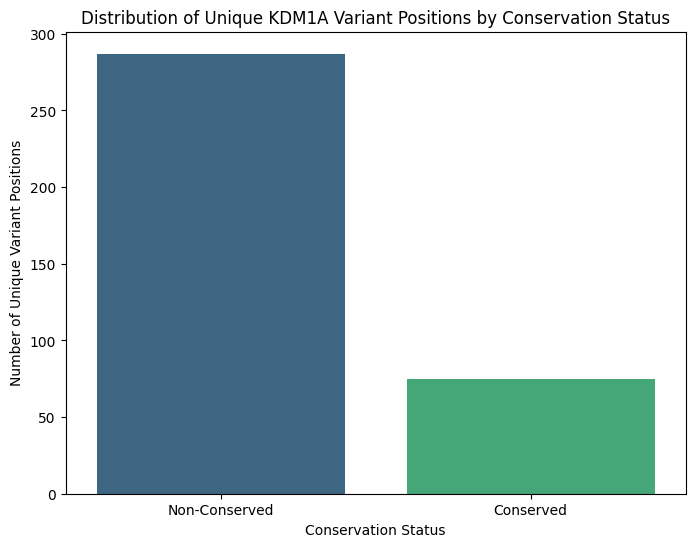

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the DataFrame is not empty
if not valid_kdm1a_clean_positions.empty:
    # Count unique variant positions in conserved and non-conserved regions
    variant_counts_by_conservation = valid_kdm1a_clean_positions.groupby('Is_Conserved_Position')['Protein_Position'].nunique().reset_index()
    variant_counts_by_conservation['Is_Conserved_Position'] = variant_counts_by_conservation['Is_Conserved_Position'].map({True: 'Conserved', False: 'Non-Conserved'})
    variant_counts_by_conservation.rename(columns={'Protein_Position': 'Unique_Variant_Positions'}, inplace=True)

    # Plotting the distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Is_Conserved_Position', y='Unique_Variant_Positions', data=variant_counts_by_conservation, palette='viridis')
    plt.title('Distribution of Unique KDM1A Variant Positions by Conservation Status')
    plt.xlabel('Conservation Status')
    plt.ylabel('Number of Unique Variant Positions')
    plt.show()
else:
    print("No valid protein positions found to visualize the distribution.")
